In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'forest-type-classification-spai:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-competitions-data%2Fkaggle-v2%2F80927%2F8721443%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240604%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240604T063856Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D502693e5361598b442593a472d2fd068e4884e9ca8fb9ff1087087f38440860640524986bdb5f3780f24fc3d893cb90b342cfc1f2a06e04dc1465d68edf4d69857a91b5f18cfd925dbb9125344941acab9c2c90d8c5541d23c76fbb87dd8fb95c013cbab6cbfeb487b3506adbc55bb55a14982150c563df7a93a3d3c603a1930f1b0d2ee0989cd158ec359dd7336657413afb8e13df66cb00930d367ed326daa2ac3023d4cfb634f70b29a5f7cb88df1bd668a7adc4a92ca4b8772d10f7d24381ae963adedf2142eaad41831de277784dd0c48afeabb6595980d5c583795511958c40550adc551033d6f0800803dfc96589a48f2c513ddd25a9a4dfd43f83707'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 473958 bytes downloaded
Downloaded and uncompressed: forest-type-classification-spai
Data source import complete.


# load data

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import os

mt_dt = pd.read_csv('/kaggle/input/forest-type-classification-spai/metaData.csv')
sp_sms = pd.read_csv('/kaggle/input/forest-type-classification-spai/sample_submission.csv')
df_train = pd.read_csv('/kaggle/input/forest-type-classification-spai/train.csv')
df_test = pd.read_csv('/kaggle/input/forest-type-classification-spai/test.csv')

In [3]:
df_train

,id,b1,b11,b12,b2,b3,b4,b5,b6,b7,b8,b8_a,b9,nforest_type
0,2002,293,1927,1038,278,475,453,987,1773,2184,1900,2343,3039,MDF
1,3212,197,1598,697,201,347,228,682,1982,2449,2254,2685,2690,DDF
2,13312,929,1975,1031,982,1020,856,1220,2051,2421,2392,2671,2683,MDF
3,17020,132,1560,689,189,408,175,609,2117,2907,3024,3005,2955,MDF
4,5967,241,1944,1131,362,538,487,918,1549,1844,1702,2077,2043,MDF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13048,9185,374,1940,1054,382,565,498,977,1678,1929,2109,2291,2100,DDF
13049,13977,1983,3602,2720,1622,1782,1766,2314,3488,3900,3924,4097,6053,DDF
13050,755,940,2007,1148,975,1080,968,1252,1780,1983,1942,2247,2170,DDF
13051,1616,1174,2312,1190,1112,1126,889,1310,2511,3085,3050,3396,3380,MDF


# feature engineer

https://www.researchgate.net/figure/Calculation-formulas-of-vegetation-index_tbl1_364536844

https://web.pdx.edu/~nauna/resources/8-2012_lecture1-vegetationindicies.pdf

In [ ]:
def feature_eng(df):
  df['SI'] = (df['b11'] - df['b4']) / (df['b11'] + df['b4'])
  df['BI'] = (df['b4'] + df['b3']) - (df['b5'] + df['b7'])
  df['NDWI'] = (df['b3'] - df['b8']) / (df['b3'] + df['b8'])
  df['MNDWI'] = (df['b3'] - df['b11']) / (df['b3'] + df['b11'])
  df['MCAR'] = ((df['b5'] - df['b4']) - 0.2 * (df['b5'] - df['b3'])) * (df['b5'] / df['b4'])
  df['Chlorophyll_Red_Edge'] = (df['b8'] / df['b5']) - 1
  df['Brightness_TC'] = 0.3037 * df['b2'] + 0.2793 * df['b3'] + 0.4743 * df['b4'] + 0.5585 * df['b8'] + 0.5082 * df['b11'] + 0.1863 * df['b12']
  df['Greenness_TC'] = -0.2848 * df['b2'] - 0.2435 * df['b3'] - 0.5436 * df['b4'] + 0.7243 * df['b8'] + 0.0840 * df['b11'] - 0.1800 * df['b12']
  df['Wetness_TC'] = 0.1509 * df['b2'] + 0.1973 * df['b3'] + 0.3279 * df['b4'] + 0.3406 * df['b8'] - 0.7112 * df['b11'] - 0.4572 * df['b12']
  df['REP_4P'] = 700 + 40 * ((df['b6'] - df['b5']) / (df['b7'] - df['b5']))

  return df

In [4]:
def supar_indice(df):
  df['ATSAVI'] = (1.22 * (df['b8'] - (1.22 * df['b4']) - 0.03)) / ((1.22 * df['b8']) + df['b4'] - (1.22 * 0.03) + (0.08 * (1 + (1.22 **2))))
  df['AFRI1600'] = df['b8'] - ((0.66*1600) / (df['b8'] + (0.66*1600)))
  df['AFRI2100'] = df['b8'] - ((0.5*2100) / (df['b8'] + (0.5*2100)))
  df['AVI'] = np.cbrt((df['b8'] * (1-df['b4']) * (df['b8'] - df['b4'])))
  df['ARVI'] = (df['b8'] - (2*df['b4']) + df['b2']) / (df['b8'] + df['b2'])
  df['ARVI2'] = ((1.17 * (df['b8'] - df['b4'])) / (df['b8'] + df['b4'])) - 0.18
  df['ARI'] = (1 / df['b3']) - (1 / df['b5'])

  df['BI'] = (df['b4'] + df['b3']) - (df['b5'] + df['b7'])
  df['BWDRVI'] = ((0.1 * df['b8']) - df['b2']) / ((0.1* df['b8']) + df['b2'])
  df['BRI'] = ((1 / 550) - (1 / 700)) / df['b8']
  df['BSI'] = (df['b4'] + df['b11'] - df['b8'] - df['b2']) / (df['b4'] + df['b11'] + df['b8'] + df['b2'])
  df['BNDVI'] = (df['b8'] - df['b2']) / (df['b8'] + df['b2'])

  df['CCCI'] = ((df['b8'] - df['b5']) / (df['b8'] + df['b5'])) / ((df['b8'] - df['b4']) / (df['b8'] + df['b4']))
  df['CIgreen'] = (df['b8'] / df['b3']) - 1 # or GCI
  df['CIrededge'] = (df['b8'] / df['b5']) - 1
  df['CVI'] = (df['b8'] * df['b4']) / (df['b3'] ** 2)
  df['CI'] = (df['b4'] - df['b2']) / df['b4']
  df['NDVI'] = (df['b8'] - df['b4']) / (df['b8'] + df['b4']) #NDVI
  df['CTVI'] = ((df['NDVI'] + 0.5) * np.sqrt(np.abs(df['NDVI'] + 0.5))) / np.abs(df['NDVI'] + 0.5)

  df['DVI'] = df['b8'] - df['b4']

  df['EVI'] = (2.5*(df['b8'] - df['b4'])) / (df['b8'] + (6*df['b4']) - (7.5*df['b2']) + 1)
  df['EVI2'] = 2.5 * (df['b8'] - df['b4']) / (df['b8'] + 2.4 * df['b4'] + 1)

  df['GDVI'] = df['b8'] - df['b3']
  n = ((2 * ((df['b8'] ** 2) - (df['b4'] ** 2))) + (1.5 * df['b8']) + (0.5 * df['b4'])) / (df['b8'] + df['b4'] + 0.5)
  df['GEMI'] = ((n * (1 - (0.25 * n))) - (df['b4'] - 0.125)) / (1 - df['b4'])
  df['GVMI'] = (df['b8'] - df['b11'] + 0.08) / (df['b8'] + df['b11'] + 0.12)
  df['GARI'] = (df['b8']-df['b3']+df['b2']-df['b4']) / (df['b8']-df['b3']-df['b2']+df['b4'])
  df['GLI'] = ((2*df['b3'])-df['b2']-df['b4']) / ((2*df['b3'])+df['b2']+df['b4'])
  df['GNDVI'] = (df['b8'] - df['b3'])/(df['b8'] + df['b3'])
  df['GSAVI'] = ((df['b8']-df['b3']) * (1 + 0.48)) / (df['b8']+df['b3']+0.48)
  df['GBNDVI'] = (df['b8'] - df['b3'] - df['b2']) / (df['b8'] + df['b3'] + df['b2'])
  df['GRNDVI'] = (df['b8'] - df['b3'] - df['b4']) / (df['b8'] + df['b3'] + df['b4'])
  df['GVI'] = df['b8'] / df['b3'] # or GRVI
  df['GNDVI'] = (df['b8'] - df['b3']) / (df['b8'] + df['b3'])

  df['H'] = np.arctan(((2 * df['b4']) - df['b3']- df['b2']) * ((df['b3'] - df['b2']) / 30.5))

  df['IPVI'] = (df['NDVI'] + 1) * ((df['b8'] / (df['b8'] + df['b4'])) / 2)
  df['I'] = (df['b4']+df['b3']+df['b2']) / 30.5
  df['IO'] = df['b4'] / df['b2']

  df['logR'] = np.log10(df['b8'] / df['b4'])

  df['RVI'] = df['b8'] / df['b4']   #RVI
  df['MRVI'] = (df['RVI'] - 1) / (df['RVI'] + 1)
  df['MSRNir/Red'] = (df['RVI'] - 1) / np.sqrt(df['RVI'] + 1)
  df['MSAVI'] = df['b8'] + ((1 - np.sqrt((((2 * df['b8']) + 1) ** 2) - (8 * (df['b8'] - df['b4'])))) / 2)
  df['MSI'] = df['b11'] / df['b8']
  df['MNDVI'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
  df['MNDWI'] = (df['b3'] - df['b11']) / (df['b3'] + df['b11'])

  df['Norm_G'] = df['b3'] / (df['b8'] + df['b4'] + df['b3'])
  df['Norm_NIR'] = df['b8'] / (df['b8'] + df['b4'] + df['b3'])
  df['Norm_R'] = df['b4'] / (df['b8'] + df['b4'] + df['b3'])
  df['NGRDI'] = (df['b3'] - df['b4']) / (df['b3'] + df['b4'])
  df['NDMI'] = (df['b8'] - df['b11']) / (df['b8'] + df['b11'])
  df['NDWI'] = (df['b3'] - df['b8']) / (df['b3'] + df['b8'])
  df['NBR'] = (df['b8'] - df['b12']) / (df['b8'] + df['b12'])
  df['NDRE'] = (df['b8'] - df['b5']) / (df['b8'] + df['b5'])

  df['PNDVI'] = (df['b8']-df['b3']-df['b4']-df['b2']) / (df['b8']+df['b3']+df['b4']+df['b2'])
  a = 1.0  # Typical slope for soil line
  b = 0.0  # Typical intercept for soil line
  df['PVI'] = (df['b8'] - a * df['b4'] - b) / np.sqrt(1 + a**2)

  df['RI'] = (df['b4'] - df['b3']) / (df['b4'] + df['b3'])
  df['RDI'] = df['b12'] / df['b8']
  df['RRI1'] = df['b8'] / df['b5']
  df['RGR'] = df['b4'] / df['b3']

  df['SI'] = (df['b11'] - df['b4']) / (df['b11'] + df['b4'])
  df['SIPI'] = (df['b8'] - df['b2']) / (df['b8'] - df['b4'])
  # df['ShapeIndex'] = ((2*df['b4']) - df['b3'] - df['b2']) / (df['b3'] - df['b2'])   # Nan value
  df['SAVImir'] = ((df['b8'] - df['b12']) * (1 + 0.48)) / (df['b8'] + df['b12'] + 0.48)
  df['SRNIR/MIR'] = df['b8'] / df['b12']
  df['SRRed/NIR'] = df['b4'] / df['b8']
  df['SLAVI'] = df['b8'] / (df['b4'] + df['b12'])

  df['TNDVI'] = np.sqrt(df['NDVI'] + 0.5)

  df['WDRVI'] = ((0.1 * df['b8']) - df['b4']) / ((0.1 * df['b8']) + df['b4'])

  # LLLm by Auan
  df['Brightness_TC'] = 0.3037 * df['b2'] + 0.2793 * df['b3'] + 0.4743 * df['b4'] + 0.5585 * df['b8'] + 0.5082 * df['b11'] + 0.1863 * df['b12']
  df['Greenness_TC'] = -0.2848 * df['b2'] - 0.2435 * df['b3'] - 0.5436 * df['b4'] + 0.7243 * df['b8'] + 0.0840 * df['b11'] - 0.1800 * df['b12']
  df['Wetness_TC'] = 0.1509 * df['b2'] + 0.1973 * df['b3'] + 0.3279 * df['b4'] + 0.3406 * df['b8'] - 0.7112 * df['b11'] - 0.4572 * df['b12']

  df['REP_4P'] = 700 + 40 * ((df['b6'] - df['b5']) / (df['b7'] - df['b5']))
  return df

In [5]:
# df_train = feature_eng(df_train)
# df_test = feature_eng(df_test)
df_train = supar_indice(df_train)
df_test = supar_indice(df_test)

In [6]:
df_train = df_train[['id', 'b1', 'b11', 'b12',	'b2', 'b3', 'b4',	'b5',	'b6',	'b7',	'b8',	'b8_a',	'b9','nforest_type', 'ARI', 'AVI', 'CVI', 'CCCI', 'CIgreen', 'CIrededge', 'EVI', 'GARI', 'GVI', 'H', 'IO', 'RVI', 'NGRDI', 'RI', 'RRI1', 'RGR', 'NDRE', 'NBR', 'NGRDI', 'MSRNir/Red','Brightness_TC', 'Greenness_TC', 'Wetness_TC', 'REP_4P']]
df_test = df_test[['id', 'b1', 'b11', 'b12',	'b2', 'b3', 'b4',	'b5',	'b6',	'b7',	'b8',	'b8_a',	'b9', 'ARI', 'AVI', 'CVI', 'CCCI', 'CIgreen', 'CIrededge', 'EVI', 'GARI', 'GVI', 'H', 'IO', 'RVI', 'NGRDI', 'RI', 'RRI1', 'RGR', 'NDRE', 'NBR', 'NGRDI', 'MSRNir/Red','Brightness_TC', 'Greenness_TC', 'Wetness_TC', 'REP_4P']]

# EDA

In [ ]:
import seaborn as sns

features = df_train.columns
target = 'nforest_type'

num_features = len(features)
num_labels = len(df_train[target].unique())
rows = num_features
cols = num_labels

# Create a figure and a set of subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, num_features * 3))

# Plot the distribution of each feature for each label
for i, feature in enumerate(features):
    for j, label in enumerate(df_train[target].unique()):
        sns.histplot(df_train[df_train[target] == label], x=feature, ax=axes[i, j], kde=True)
        axes[i, j].set_title(f'{feature} (Label: {label})')

# Adjust layout
plt.tight_layout()
plt.show()

Output hidden; open in https://colab.research.google.com to view.

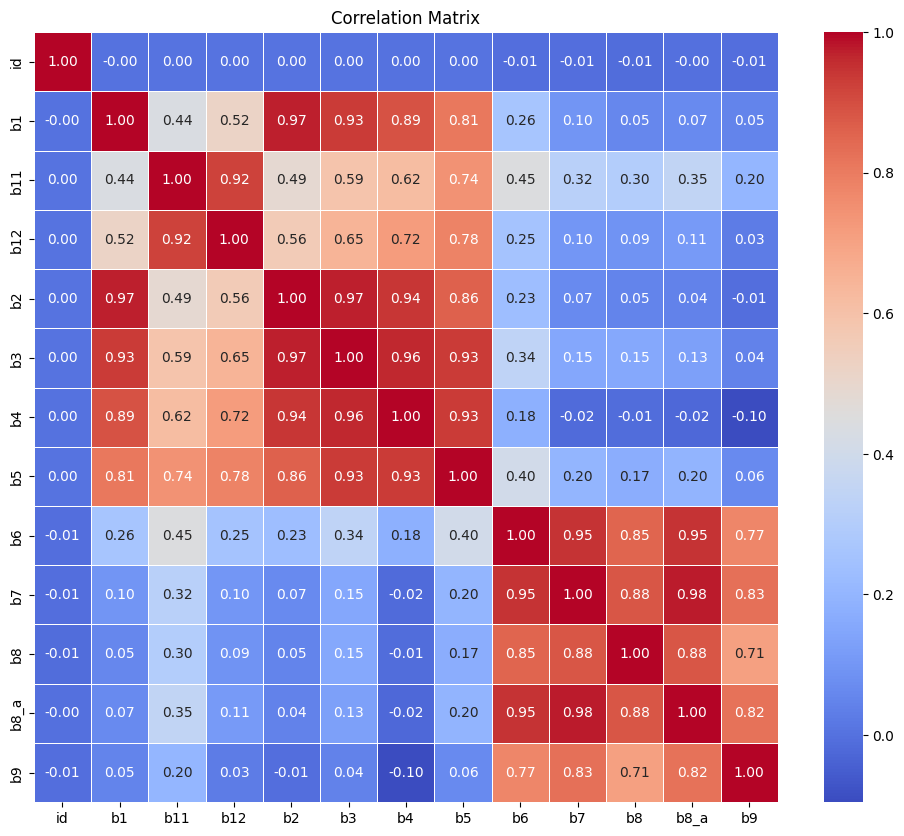

In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
correlation_matrix = df_train.drop(columns=['nforest_type']).corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 10))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", cmap="coolwarm", linewidths=.5)

# Set the title
plt.title('Correlation Matrix')

# Show the plot
plt.show()

# prepare data

In [7]:
from sklearn.model_selection import train_test_split, GridSearchCV, ParameterGrid, StratifiedKFold
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, classification_report

## Normalize & Encoder

In [8]:
# # Separate features and target variable from training data
X = df_train.drop(columns=['id', 'nforest_type'])
y = df_train['nforest_type']

# For the test set, we only have features
X_test = df_test.drop(columns=['id'])

In [9]:
col_ls = list(X.columns)
col_ls.append('nforest_type')
len(col_ls)

37

In [10]:
scaler = MinMaxScaler()
X_scaled = scaler.fit_transform(X)
X_test_scaled = scaler.transform(X_test)

label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

In [ ]:
# Split the data into training and validation sets
X_train_scaled, X_val_scaled, y_train_encoded, y_val_encoded = train_test_split(X_scaled, y_encoded, test_size=0.25, random_state=888, stratify=y)

In [ ]:
pd.DataFrame(y_train_encoded).value_counts()

2    4398
0    3452
1    1939
Name: count, dtype: int64

In [ ]:
pd.DataFrame(y_val_encoded).value_counts()

2    1467
0    1151
1     646
Name: count, dtype: int64

## SMOTE

In [18]:
from imblearn.over_sampling import SMOTE

In [13]:
smote = SMOTE(sampling_strategy='not majority')
Xs_res, ye_res = smote.fit_resample(X_scaled, y_encoded)
pd.Series(ye_res).value_counts()

2    5865
0    5865
1    5865
Name: count, dtype: int64

In [17]:
smote = SMOTE(sampling_strategy='not majority')
Xts_res, yte_res = smote.fit_resample(X_train_scaled, y_train_encoded)

In [ ]:
pd.Series(yte_res).value_counts()

0    4398
2    4398
1    4398
Name: count, dtype: int64

## SMOTE & TomekLinks (useless now)

In [ ]:
Xy = pd.concat([pd.DataFrame(X_train_scaled), pd.DataFrame(y_train_encoded)], axis=1)
Xy.columns = col_ls
Xy['nforest_type'].value_counts()

nforest_type
2    4398
0    3452
1    1939
Name: count, dtype: int64

In [ ]:
Xy_2 = Xy.loc[~(Xy['nforest_type'] == 2)]
Xy_2.nforest_type.value_counts()

nforest_type
0    3452
1    1939
Name: count, dtype: int64

In [ ]:
from imblearn.over_sampling import SMOTE

Xx = Xy_2.drop(["nforest_type"], axis=1)
yy = Xy_2['nforest_type']

smote = SMOTE(sampling_strategy='minority')
Xts_res, yte_res = smote.fit_resample(Xx, yy)

In [ ]:
Xy_2 = pd.concat([Xts_res, yte_res], axis=1)
Xy_2.nforest_type.value_counts()

nforest_type
0    3452
1    3452
Name: count, dtype: int64

In [ ]:
Xy = pd.concat([Xy_2, Xy.loc[Xy['nforest_type'] == 2]])
Xy.nforest_type.value_counts()

nforest_type
2    4398
0    3452
1    3452
Name: count, dtype: int64

In [ ]:
from imblearn.under_sampling import TomekLinks

Xx = Xy.drop(["nforest_type"], axis=1)
yy = Xy['nforest_type']

tl = TomekLinks(sampling_strategy='majority')
Xts_res, yte_res = tl.fit_resample(Xx, yy)

yte_res.value_counts()

nforest_type
2    3857
0    3452
1    3452
Name: count, dtype: int64

# training & eva

## mlp sklearn

In [ ]:
from sklearn.neural_network import MLPClassifier
# Define the model with early stopping and validation fraction
model = MLPClassifier(hidden_layer_sizes=(32,64,128,512,128,64,32,16),
                      max_iter=2000,
                      early_stopping=True,
                      validation_fraction=0.2,
                      n_iter_no_change=10)
model.fit(X_scaled, y_encoded)

MLPClassifier(early_stopping=True,
              hidden_layer_sizes=(32, 64, 128, 512, 128, 64, 32, 16),
              max_iter=2000, validation_fraction=0.2)

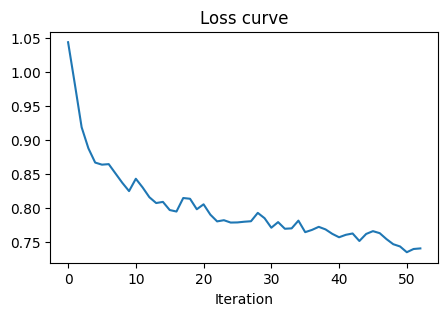

In [ ]:
plt.figure(figsize=(5,3))
plt.title('Loss curve')
plt.xlabel('Iteration')
plt.plot(model.loss_curve_)
plt.show()

In [ ]:
preds = model.predict(X_encoded)
pred_labels = label_encoder.inverse_transform(preds)

accuracy = accuracy_score(y, pred_labels)
print("MLP Accuracy:", accuracy)
print(classification_report(y, pred_labels))

MLP Accuracy: 0.6648280088868459
              precision    recall  f1-score   support

         DDF       0.66      0.52      0.58      4603
         DEF       0.74      0.65      0.69      2585
         MDF       0.64      0.79      0.71      5865

    accuracy                           0.66     13053
   macro avg       0.68      0.65      0.66     13053
weighted avg       0.67      0.66      0.66     13053



In [ ]:
model.best_validation_score_, model.loss_

(0.6476445806204519, 0.7403166440118497)

## random forrest

In [ ]:
from sklearn.ensemble import RandomForestClassifier
# Create the RandomForestClassifier
model = RandomForestClassifier(n_estimators=100, random_state=888)
# Train the model
model.fit(X_train_scaled, y_train_encoded)

In [ ]:
# Evaluate the model on the validation set
y_val_pred = model.predict(X_val_scaled)
y_val_pred_labels = label_encoder.inverse_transform(y_val_pred)

accuracy = accuracy_score(y_val, y_val_pred_labels)
print(f'Validation Accuracy: {accuracy}')
print(classification_report(y_val, y_val_pred_labels))

## light GBM

### intro

In [ ]:
from lightgbm import LGBMClassifier

In [ ]:
params = {
    "colsample_bynode": 0.8,
    "colsample_bytree": 0.8,
    "learning_rate": 0.05,
    "l1_regularization": 0.1,
    "l2_regularization": 10,
    "max_depth": 20,
    "n_estimators": 2000,
    "num_leaves": 64,
}

model = LGBMClassifier(**params,
                       objective="multiclass",
                       boosting_type="gbdt",
                       extra_trees=True,
                       device="cpu",
                       seed=888,
                       verbose=-1)
model.fit(np.array(Xts_res), np.array(yte_res),
          eval_set=[(X_val_scaled, y_val_encoded)])

y_val_pred = model.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f'Validation Accuracy: {accuracy}')

# Print classification report
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.6893382352941176
              precision    recall  f1-score   support

           0       0.66      0.63      0.65      1151
           1       0.73      0.72      0.72       646
           2       0.69      0.72      0.71      1467

    accuracy                           0.69      3264
   macro avg       0.69      0.69      0.69      3264
weighted avg       0.69      0.69      0.69      3264



### optuna

In [ ]:
!pip -q install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 8.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 9.5 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler

# Objective function for Optuna
def objective(trial):

    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 64),
        'l1_regularization': trial.suggest_float('l1_regularization', 1e-3, 10.0),
        'l2_regularization': trial.suggest_float('l2_regularization', 1e-3, 10.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.05, 1.0),
        "num_leaves": trial.suggest_int("num_leaves", 2, 80),
    }



    stkf = StratifiedKFold(n_splits=10, shuffle=True)  # do not set random_state
    total_acc = 0

    for train_idx, val_idx in stkf.split(X_scaled, y_encoded):
      X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
      y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

      # smote
      smote = SMOTE(sampling_strategy='not majority')

      X_train, y_train = smote.fit_resample(X_train, y_train)
      ##################################################################

      model = LGBMClassifier(**params,
                            objective="multiclass",
                            boosting_type="gbdt",
                            extra_trees=True,
                            device="gpu",
                            seed=888,
                            verbose=-1)
      model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)])

      y_val_pred = model.predict(X_val)
      accuracy = accuracy_score(y_val, y_val_pred)
      total_acc += accuracy

    # Average accuracy across folds
    avg_acc = total_acc / stkf.get_n_splits()
    return avg_acc

In [ ]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=888))
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
best_params

[I 2024-06-06 12:42:06,883] A new study created in memory with name: no-name-79eac189-b997-4913-931f-11ac9a0b64f7
[W 2024-06-06 12:42:07,152] Trial 0 failed with parameters: {'n_estimators': 3509, 'learning_rate': 0.008186152939213974, 'max_depth': 31, 'l1_regularization': 9.210351634732245, 'l2_regularization': 4.286135856742223, 'colsample_bytree': 0.10458708794650709, 'colsample_bynode': 0.9287570627078754, 'num_leaves': 53} because of the following error: LightGBMError('No OpenCL device found').
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-34-31f2fba536e5>", line 39, in objective
    model.fit(Xts_res, yte_res,
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 1142, in fit
    super().fit(
  File "/usr/local/lib/python3.10/dist-packages/lightgbm/sklearn.py", line 842, in fit
    self._Booster = train(
  File "/us

LightGBMError: No OpenCL device found

In [ ]:
# ohm feature: val_score = 0.697617066610318
best_params = {'n_estimators': 3672,
 'learning_rate': 0.022020635748662965,
 'max_depth': 53,
 'l1_regularization': 0.2514110389285493,
 'l2_regularization': 4.26362216324058,
 'colsample_bytree': 0.995762059102777,
 'colsample_bynode': 0.46284779759167743,
 'num_leaves': 24}

 # ohm feature: val_score = 0.697617066610318

In [ ]:
model = LGBMClassifier(**best_params,
                       objective="multiclass",
                       boosting_type="gbdt",
                       extra_trees=True,
                       device="cpu",
                       seed=888,
                       verbose=-1)
model.fit(np.array(Xts_res), np.array(yte_res),
          eval_set=[(X_val_scaled, y_val_encoded)])

y_val_pred = model.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f'Validation Accuracy: {accuracy}')

# Print classification report
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.694546568627451
              precision    recall  f1-score   support

           0       0.66      0.65      0.65      1151
           1       0.72      0.77      0.74       646
           2       0.71      0.70      0.70      1467

    accuracy                           0.69      3264
   macro avg       0.70      0.70      0.70      3264
weighted avg       0.69      0.69      0.69      3264



### feature importance

Text(0.5, 1.0, 'Feature Importance')

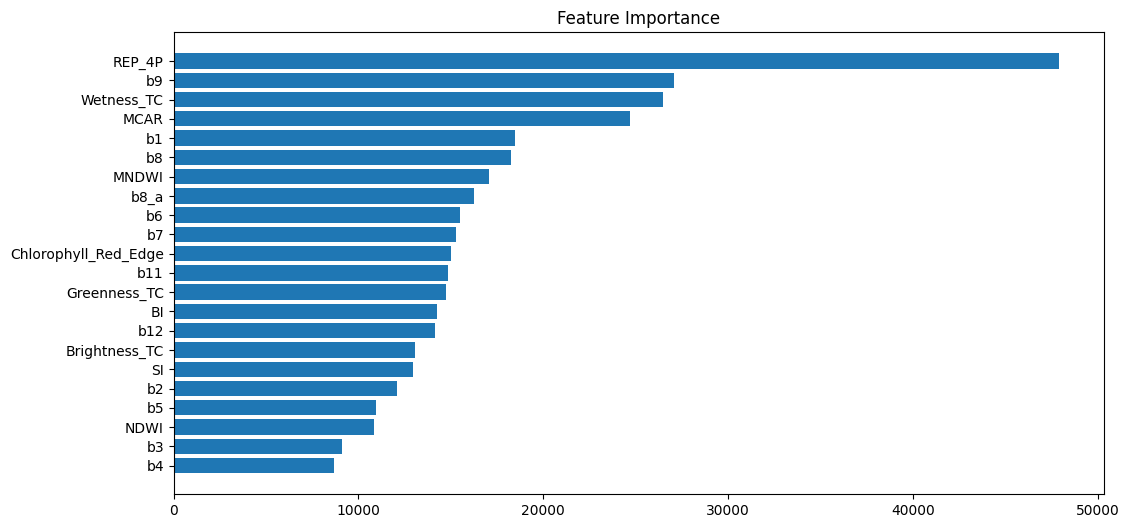

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
cols = col_ls[:-1] # remove nforest_type
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cols)[sorted_idx])
plt.title('Feature Importance')


## xgboost

### intro

In [ ]:
import xgboost as xgb

In [ ]:
# Create the DMatrix for XGBoost and specify the device (GPU)
# dtrain = xgb.DMatrix(Xts_res, yte_res, nthread=-1)
# dval = xgb.DMatrix(X_val_scaled, y_val_encoded, nthread=-1)
# dtest = xgb.DMatrix(X_test_scaled, nthread=-1)

params = {
    'max_depth': 20,
    'lambda': 0.1,
    'alpha': 10,
    'learning_rate': 0.05,
    'subsample': 0.2,
    "colsample_bytree": 0.8,
    "colsample_bynode": 0.8,
    "min_child_weight": 5,
    'n_estimators':1000,
}

model = xgb.XGBClassifier(**params,
                          objective='multi:softmax',
                          device='cuda', # cuda:0 -> method=hist
                          verbosity=0,
                          num_class=len(label_encoder.classes_),
                          use_label_encoder=False,
                          seed=888,
                          early_stopping_rounds=10)

# Train the model
model.fit(np.array(Xts_res), np.array(yte_res),
          eval_set=[(X_val_scaled, y_val_encoded)], verbose=False)

XGBClassifier(alpha=10, base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=0.8,
              colsample_bytree=0.8, device='cuda', early_stopping_rounds=10,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=0.1, learning_rate=0.05,
              max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=20, max_leaves=None,
              min_child_weight=5, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=1000, n_jobs=None, ...)

In [ ]:
# Predict on validation set
y_val_pred = model.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f'Validation Accuracy: {accuracy}')

# Print classification report
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.6663602941176471
              precision    recall  f1-score   support

           0       0.65      0.59      0.62      1151
           1       0.64      0.78      0.70       646
           2       0.69      0.68      0.68      1467

    accuracy                           0.67      3264
   macro avg       0.66      0.68      0.67      3264
weighted avg       0.67      0.67      0.66      3264



### optuna

In [ ]:
!pip -q install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 11.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 29.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 11.5 MB/s eta 0:00:00


In [ ]:
import optuna
from optuna.samplers import TPESampler

# Objective function for Optuna
def objective(trial):
    params = {
        "n_estimators": trial.suggest_int("n_estimators", 500, 4000),
        "learning_rate": trial.suggest_float("learning_rate", 0.005, 0.1, log=True),
        "max_depth": trial.suggest_int("max_depth", 1, 32),
        'lambda': trial.suggest_float('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_float('alpha', 1e-3, 10.0),
        "subsample": trial.suggest_float("subsample", 0.05, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.05, 1.0),
        "colsample_bynode": trial.suggest_float("colsample_bynode", 0.05, 1.0),
        "min_child_weight": trial.suggest_float("min_child_weight", 1, 300),
    }

    stkf = StratifiedKFold(n_splits=5, shuffle=True)  # do not set random_state
    total_acc = 0

    for train_idx, val_idx in stkf.split(X_scaled, y_encoded):
      X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
      y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

      # smote
      smote = SMOTE(sampling_strategy='not majority')

      X_train, y_train = smote.fit_resample(X_train, y_train)
      ##################################################################

      model = xgb.XGBClassifier(**params,
                          objective='multi:softmax',
                          device='cuda', # cuda:0 -> method=hist
                          verbosity=0,
                          num_class=len(label_encoder.classes_),
                          use_label_encoder=False,
                          seed=888,
                          early_stopping_rounds=10)
      model.fit(X_train, y_train,
                eval_set=[(X_val, y_val)])

      y_val_pred = model.predict(X_val)
      accuracy = accuracy_score(y_val, y_val_pred)
      total_acc += accuracy

    # Average accuracy across folds
    avg_acc = total_acc / stkf.get_n_splits()
    return avg_acc

In [ ]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=888))
study.optimize(objective, n_trials=40)

# Get the best hyperparameters
best_params = study.best_params
best_params

[I 2024-06-06 04:25:09,437] A new study created in memory with name: no-name-834287ce-1e29-49b2-a26c-fda73e911a79
[I 2024-06-06 04:26:24,765] Trial 0 finished with value: 0.6318096588116002 and parameters: {'n_estimators': 3509, 'learning_rate': 0.008186152939213974, 'max_depth': 16, 'lambda': 9.210351634732245, 'alpha': 4.286135856742223, 'subsample': 0.10458708794650709, 'colsample_bytree': 0.9287570627078754, 'colsample_bynode': 0.6747214614640505, 'min_child_weight': 40.752898598370905}. Best is trial 0 with value: 0.6318096588116002.
[I 2024-06-06 04:26:46,877] Trial 1 finished with value: 0.6670505714843331 and parameters: {'n_estimators': 2367, 'learning_rate': 0.07399755081029973, 'max_depth': 8, 'lambda': 0.3026880242558114, 'alpha': 0.725399024153646, 'subsample': 0.8804562700947396, 'colsample_bytree': 0.5805088331042983, 'colsample_bynode': 0.9202449894318874, 'min_child_weight': 190.40467336153415}. Best is trial 1 with value: 0.6670505714843331.
[I 2024-06-06 04:27:18,619

{'n_estimators': 2545,
 'learning_rate': 0.030312402618414676,
 'max_depth': 29,
 'lambda': 3.9410705514928686,
 'alpha': 4.837852994429205,
 'subsample': 0.8993275809401318,
 'colsample_bytree': 0.8383987302764818,
 'colsample_bynode': 0.9945482713831311,
 'min_child_weight': 16.36151941228406}

In [ ]:
# val score = 0.6881181444258082
best_params = {'n_estimators': 2545,
 'learning_rate': 0.030312402618414676,
 'max_depth': 29,
 'lambda': 3.9410705514928686,
 'alpha': 4.837852994429205,
 'subsample': 0.8993275809401318,
 'colsample_bytree': 0.8383987302764818,
 'colsample_bynode': 0.9945482713831311,
 'min_child_weight': 16.36151941228406}

In [ ]:
model = xgb.XGBClassifier(**best_params,
                          objective='multi:softmax',
                          device='cuda', # cuda:0 -> method=hist
                          verbosity=0,
                          num_class=len(label_encoder.classes_),
                          use_label_encoder=False,
                          seed=888,
                          early_stopping_rounds=10)

# Train the model
model.fit(np.array(Xts_res), np.array(yte_res),
          eval_set=[(X_val_scaled, y_val_encoded)], verbose=False)

y_val_pred = model.predict(X_val_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f'Validation Accuracy: {accuracy}')

# Print classification report
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.6807598039215687
              precision    recall  f1-score   support

           0       0.64      0.63      0.63      1151
           1       0.69      0.78      0.73       646
           2       0.71      0.68      0.70      1467

    accuracy                           0.68      3264
   macro avg       0.68      0.69      0.69      3264
weighted avg       0.68      0.68      0.68      3264



### feature importance

Text(0.5, 1.0, 'Feature Importance')

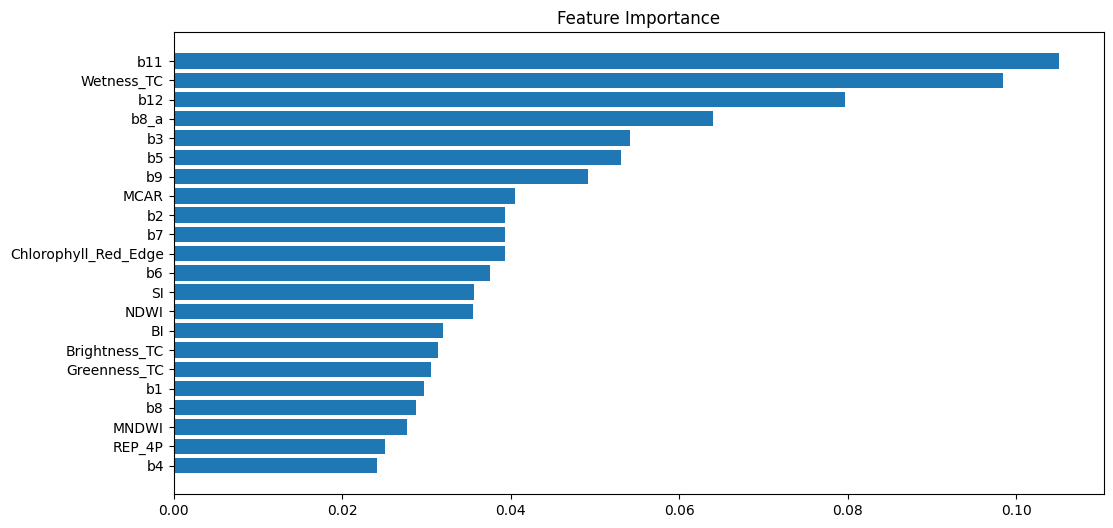

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
cols = col_ls[:-1] # remove nforest_type
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cols)[sorted_idx])
plt.title('Feature Importance')


## catboost

In [11]:
!pip install catboost

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.2/98.2 MB 9.1 MB/s eta 0:00:00


In [12]:
from catboost import CatBoostClassifier, Pool

### intro

In [ ]:
train_pool = Pool(Xts_res, yte_res)
val_pool = Pool(X_val_scaled, y_val_encoded)

model = CatBoostClassifier(
    best_model_min_trees = 2000,
    boosting_type = "Plain",
    eval_metric = "Accuracy",
    learning_rate = 0.05,
    l2_leaf_reg = 10,
    max_leaves = 64,
    random_seed = 888,
    task_type = "GPU",
    use_best_model = True
)
model.fit(train_pool, eval_set=val_pool, verbose=False)

y_val_pred = model.predict(X_val_scaled)

accuracy = accuracy_score(y_val_encoded, y_val_pred)
print(f'Validation Accuracy: {accuracy}')
print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.6798406862745098
              precision    recall  f1-score   support

           0       0.65      0.62      0.63      1151
           1       0.67      0.78      0.72       646
           2       0.71      0.68      0.70      1467

    accuracy                           0.68      3264
   macro avg       0.68      0.69      0.68      3264
weighted avg       0.68      0.68      0.68      3264



### optuna

In [21]:
!pip -q install optuna

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.4/233.4 kB 28.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 12.2 MB/s eta 0:00:00


In [22]:
import optuna
from optuna.samplers import TPESampler

# Objective function for Optuna
def objective(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 2000),
        'border_count': trial.suggest_int('border_count', 1, 255),
        'bagging_temperature': trial.suggest_float('bagging_temperature', 0.0, 1.0),
        'depth': trial.suggest_int('depth', 4, 16),
        'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.1, log=True),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-3, 10, log=True),
        'max_leaves': trial.suggest_int('max_leaves', 2, 80),
        'random_seed': 888,
        'task_type': 'GPU',
        'use_best_model': True,
        'eval_metric': 'Accuracy',
        'grow_policy': 'Lossguide',
        'boosting_type': 'Plain'
    }

    stkf = StratifiedKFold(n_splits=10, shuffle=True)  # do not set random_state
    total_acc = 0

    for train_idx, val_idx in stkf.split(X_scaled, y_encoded):
      X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
      y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

      # smote
      smote = SMOTE(sampling_strategy='not majority')

      X_train, y_train = smote.fit_resample(X_train, y_train)
      ##################################################################

      train_pool = Pool(X_train, y_train)
      val_pool = Pool(X_val, y_val)

      model = CatBoostClassifier(**params)
      model.fit(train_pool, eval_set=val_pool, verbose=False)

      y_val_pred = model.predict(X_val)
      accuracy = accuracy_score(y_val, y_val_pred)
      total_acc += accuracy

    # Average accuracy across folds
    avg_acc = total_acc / stkf.get_n_splits()
    return avg_acc

In [23]:
# Create a study object and optimize the objective function
study = optuna.create_study(direction='maximize', sampler=TPESampler(seed=888))
study.optimize(objective, n_trials=50)

# Get the best hyperparameters
best_params = study.best_params
best_params

[I 2024-06-06 17:23:09,297] A new study created in memory with name: no-name-a67fb1e2-4c18-4f84-9614-5ecaa8331594
[I 2024-06-06 17:31:46,092] Trial 0 finished with value: 0.7000692940921065 and parameters: {'iterations': 1734, 'border_count': 42, 'bagging_temperature': 0.4834759591551415, 'depth': 15, 'learning_rate': 0.018052393407301894, 'l2_leaf_reg': 0.0016976195590890342, 'max_leaves': 75}. Best is trial 0 with value: 0.7000692940921065.
[I 2024-06-06 17:32:59,407] Trial 1 finished with value: 0.6537964478710108 and parameters: {'iterations': 1350, 'border_count': 34, 'bagging_temperature': 0.5334489250623607, 'depth': 15, 'learning_rate': 0.010522047671514236, 'l2_leaf_reg': 0.0013203445539112292, 'max_leaves': 7}. Best is trial 0 with value: 0.7000692940921065.
[I 2024-06-06 17:35:08,524] Trial 2 finished with value: 0.6665883367657671 and parameters: {'iterations': 1761, 'border_count': 143, 'bagging_temperature': 0.9160473572967236, 'depth': 12, 'learning_rate': 0.011681272274

{'iterations': 1981,
 'border_count': 179,
 'bagging_temperature': 0.5321224591936926,
 'depth': 15,
 'learning_rate': 0.057594837270947837,
 'l2_leaf_reg': 0.03770872402240005,
 'max_leaves': 45}

In [14]:
# ohm feature
# best_params = {'iterations': 1084,
#                'border_count': 146,
#                'bagging_temperature': 0.5463330462648589,
#                'depth': 5, 'learning_rate': 0.044180689309352913,
#                'l2_leaf_reg': 5.759767582243575,
#                'max_leaves': 40}

# art bias feature
best_params = {'iterations': 1981,
 'border_count': 179,
 'bagging_temperature': 0.5321224591936926,
 'depth': 15,
 'learning_rate': 0.057594837270947837,
 'l2_leaf_reg': 0.03770872402240005,
 'max_leaves': 45}

In [24]:
# Train the final model with the best hyperparameters

stkf = StratifiedKFold(n_splits=10, shuffle=True)  # do not set random_state
model_ls = []
total_acc = 0

for train_idx, val_idx in stkf.split(X_scaled, y_encoded):
    X_train, X_val = X_scaled[train_idx], X_scaled[val_idx]
    y_train, y_val = y_encoded[train_idx], y_encoded[val_idx]

    # smote
    smote = SMOTE(sampling_strategy='not majority')

    X_train, y_train = smote.fit_resample(X_train, y_train)
    ##################################################################

    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)

    model = CatBoostClassifier(
        **best_params,
        random_seed=888,
        task_type='GPU',
        use_best_model=True,
        eval_metric='Accuracy',
        grow_policy='Lossguide',
        boosting_type='Plain'
    )
    model.fit(train_pool, eval_set=val_pool, verbose=False)
    model_ls.append(model)

    y_val_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_val_pred)
    total_acc += accuracy

# Average accuracy across folds
avg_acc = total_acc / stkf.get_n_splits()

print(f'Validation Accuracy: {avg_acc}')
# print(classification_report(y_val_encoded, y_val_pred))

Validation Accuracy: 0.7033617902636227


In [25]:
model_ls

### feature importance

Text(0.5, 1.0, 'Feature Importance')

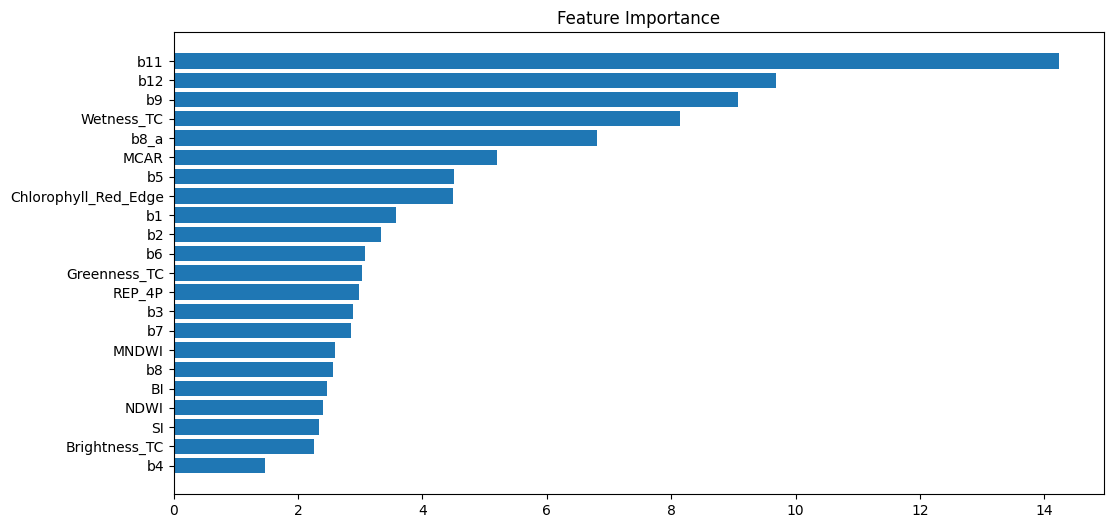

In [ ]:
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
cols = col_ls[:-1] # remove nforest_type
fig = plt.figure(figsize=(12, 6))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(cols)[sorted_idx])
plt.title('Feature Importance')


In [ ]:
feature_importance

array([ 3.57323343, 14.23938446,  9.67778978,  3.34048227,  2.8894832 ,
        1.476696  ,  4.506537  ,  3.07414479,  2.84980827,  2.56125833,
        6.81068418,  9.07911033,  2.34145038,  2.4585186 ,  2.40751861,
        2.60006432,  5.20533566,  4.48527826,  2.26286646,  3.02318333,
        8.14863248,  2.98853985])

In [ ]:
sorted_idx

array([ 5, 18, 12, 14, 13,  9, 15,  8,  4, 21, 19,  7,  3,  0, 17,  6, 16,
       10, 20, 11,  2,  1])

# submission

## light gbm

In [ ]:
# Predict the classes
y_test_pred = model.predict(X_test_scaled)

# Convert numerical predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_test_pred.astype(int))
y_pred_labels

array(['DEF', 'MDF', 'MDF', ..., 'DDF', 'MDF', 'DEF'], dtype=object)

In [ ]:
sp_sms.loc[3:, 'nforest_type'] = y_pred_labels[3:]
sp_sms

,id,nforest_type
0,13467,DEF
1,12719,DDF
2,1054,MDF
3,13747,DDF
4,9453,DDF
...,...,...
3995,115,DEF
3996,10654,MDF
3997,5718,DDF
3998,13054,MDF


In [ ]:
sp_sms['nforest_type'].value_counts()

nforest_type
MDF    1573
DDF    1451
DEF     976
Name: count, dtype: int64

In [ ]:
# Save the submission to a CSV file
sp_sms.to_csv('lgbm_feaOhm_bestParam.csv', index=False)

## xgboost

In [ ]:
# Predict the classes
y_test_pred = model.predict(X_test_scaled)
# y_test_pred = model.predict(dtest)

# Convert numerical predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_test_pred.astype(int))
y_pred_labels

array(['DEF', 'MDF', 'MDF', ..., 'DDF', 'MDF', 'DEF'], dtype=object)

In [ ]:
sp_sms.loc[3:, 'nforest_type'] = y_pred_labels[3:]
sp_sms

,id,nforest_type
0,13467,DEF
1,12719,DDF
2,1054,MDF
3,13747,DDF
4,9453,DEF
...,...,...
3995,115,DEF
3996,10654,MDF
3997,5718,DDF
3998,13054,MDF


In [ ]:
sp_sms['nforest_type'].value_counts()

nforest_type
MDF    1541
DDF    1451
DEF    1008
Name: count, dtype: int64

In [ ]:
# Save the submission to a CSV file
sp_sms.to_csv('xgb_feaOhm_bestParam.csv', index=False)

## catboost

### normal

In [ ]:
# Predict the classes
y_test_pred = model.predict(X_test_scaled)

# Convert numerical predictions back to original labels
y_pred_labels = label_encoder.inverse_transform(y_test_pred.astype(int))
y_pred_labels

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:155: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


array(['DEF', 'DDF', 'MDF', ..., 'DEF', 'MDF', 'DEF'], dtype=object)

In [ ]:
sp_sms.loc[3:, 'nforest_type'] = y_pred_labels[3:]
sp_sms

,id,nforest_type
0,13467,DEF
1,12719,DDF
2,1054,MDF
3,13747,DDF
4,9453,DDF
...,...,...
3995,115,DEF
3996,10654,MDF
3997,5718,DEF
3998,13054,MDF


In [ ]:
sp_sms['nforest_type'].value_counts() #best ohm

nforest_type
MDF    1515
DDF    1484
DEF    1001
Name: count, dtype: int64

In [ ]:
sp_sms['nforest_type'].value_counts() #best art

nforest_type
MDF    1551
DDF    1453
DEF     996
Name: count, dtype: int64

### ensemble 10 kfold

In [26]:
pred_cols = []

for i in range(len(model_ls)):
  # Predict the classes
  y_test_pred = model_ls[i].predict(X_test_scaled)

  if i == 0:
    pred_df = pd.DataFrame(y_test_pred)
  else:
    pred_df = pd.concat([pred_df, pd.DataFrame(y_test_pred)], axis=1)
  pred_cols.append("fold_" + str(i + 1))
  pred_df.columns = pred_cols
del pred_cols

In [27]:
pred_df

,fold_1,fold_2,fold_3,fold_4,fold_5,fold_6,fold_7,fold_8,fold_9,fold_10
0,1,1,1,1,1,1,1,1,1,1
1,0,2,2,0,2,2,2,2,2,2
2,2,2,2,2,2,2,2,2,2,2
3,0,2,0,0,0,0,0,0,0,0
4,0,0,1,0,1,1,1,2,1,0
...,...,...,...,...,...,...,...,...,...,...
3995,1,1,1,1,1,1,1,1,1,2
3996,2,2,2,2,2,2,2,2,2,2
3997,1,0,1,0,0,1,0,1,0,1
3998,2,2,2,2,2,2,2,2,2,2


In [31]:
for i in pred_df.columns:
  print(pred_df[i].value_counts(), "\n")

fold_1
2    1572
0    1464
1     964
Name: count, dtype: int64 

fold_2
2    1594
0    1402
1    1004
Name: count, dtype: int64 

fold_3
2    1575
0    1451
1     974
Name: count, dtype: int64 

fold_4
2    1581
0    1440
1     979
Name: count, dtype: int64 

fold_5
2    1575
0    1443
1     982
Name: count, dtype: int64 

fold_6
2    1569
0    1464
1     967
Name: count, dtype: int64 

fold_7
2    1606
0    1406
1     988
Name: count, dtype: int64 

fold_8
2    1572
0    1433
1     995
Name: count, dtype: int64 

fold_9
2    1578
0    1426
1     996
Name: count, dtype: int64 

fold_10
2    1563
0    1454
1     983
Name: count, dtype: int64 



In [34]:
ens_pred = pred_df.mode(axis=1)
ens_pred

,0,1
0,1.0,NaN
1,2.0,NaN
2,2.0,NaN
3,0.0,NaN
4,1.0,NaN
...,...,...
3995,1.0,NaN
3996,2.0,NaN
3997,0.0,1.0
3998,2.0,NaN


In [35]:
for i in ens_pred.columns:
  print(ens_pred[i].value_counts(), "\n")

0
2.0    1541
0.0    1480
1.0     979
Name: count, dtype: int64 

1
2.0    78
1.0    20
Name: count, dtype: int64 



In [36]:
y_pred_labels = label_encoder.inverse_transform(np.array(ens_pred[0]).astype(int))
y_pred_labels

array(['DEF', 'MDF', 'MDF', ..., 'DDF', 'MDF', 'DEF'], dtype=object)

In [37]:
sp_sms.loc[3:, 'nforest_type'] = y_pred_labels[3:]
sp_sms

,id,nforest_type
0,13467,DEF
1,12719,DDF
2,1054,MDF
3,13747,DDF
4,9453,DEF
...,...,...
3995,115,DEF
3996,10654,MDF
3997,5718,DDF
3998,13054,MDF


In [38]:
sp_sms.nforest_type.value_counts()

nforest_type
MDF    1540
DDF    1481
DEF     979
Name: count, dtype: int64

In [39]:
# Save the submission to a CSV file
# sp_sms.to_csv('cb_feaOhm_bestParam.csv', index=False)
sp_sms.to_csv('cb_smote_feaARTbias_ens10kfold.csv', index=False)

## ensemble csv

In [ ]:
df_ensemble = pd.concat([df1,df2,df3])

df_ensemble = df_ensemble.groupby("i")["pred"].apply(lambda x: x.mode()[0]).reset_index()

df_ensemble

## compare

In [ ]:
latest = pd.read_csv('/kaggle/working/mlp.csv')
latest['nforest_type'].value_counts()

nforest_type
DDF    3364
DEF     635
MDF       1
Name: count, dtype: int64

In [ ]:
latest = pd.read_csv('/kaggle/working/mlp_3.csv')
latest['nforest_type'].value_counts()

nforest_type
DEF    3270
MDF     729
DDF       1
Name: count, dtype: int64

In [ ]:
compare = pd.concat([sp_sms, latest], axis=1)
compare.columns = ['id','new_class','id2','old_class']
compare

,id,new_class,id2,old_class
0,13467,DEF,13467,DEF
1,12719,DDF,12719,DDF
2,1054,MDF,1054,MDF
3,13747,MDF,13747,DDF
4,9453,MDF,9453,DDF
...,...,...,...,...
3995,115,MDF,115,DDF
3996,10654,MDF,10654,DDF
3997,5718,MDF,5718,DDF
3998,13054,MDF,13054,DEF


In [ ]:
compare[compare.new_class != compare.old_class]

,id,new_class,id2,old_class
3,13747,MDF,13747,DDF
4,9453,MDF,9453,DDF
5,8491,MDF,8491,DDF
6,4410,MDF,4410,DDF
7,12926,MDF,12926,DDF
...,...,...,...,...
3995,115,MDF,115,DDF
3996,10654,MDF,10654,DDF
3997,5718,MDF,5718,DDF
3998,13054,MDF,13054,DEF
